In [4]:
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [8]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 600 # Time in seconds for automl run
TARGET_NAME = 'final_price' # Target column name

In [9]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
submission = pd.read_csv('sample_submission.csv')

In [10]:
def create_expert_feats(data):
    pass

create_expert_feats(train_data)
create_expert_feats(test_data)

In [11]:
task = Task('reg', )

In [12]:
roles = {'target': TARGET_NAME,
         'drop': ['row_ID'] # to drop or not to drop?
         }

In [13]:
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

n_data_in_leaf': 3}. Best is trial 53 with value: -6356025288.986981.
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	learn: 71285.8171831	test: 79824.4467379	best: 79824.4467379 (0)	total: 1.72ms	remaining: 3.43s
100:	learn: 40246.3098471	test: 79734.6396304	best: 79734.6396304 (100)	total: 145ms	remaining: 2.72s
200:	learn: 30228.4718235	test: 79726.8314176	best: 79725.8994913 (194)	total: 294ms	remaining: 2.63s
300:	learn: 23615.6111900	test: 79726.3804869	best: 79725.2569067 (291)	total: 439ms	remaining: 2.48s
400:	learn: 19383.5904896	test: 79728.0639486	best: 79724.6894739 (317)	total: 554ms	remaining: 2.21s
500:	learn: 17318.2655258	test: 79729.6609498	best: 79724.6894739 (317)	total: 669ms	remaining: 2s
600:	learn: 15468.2666638	test: 79732.7458897	best: 79724.6894739 (317)	total: 812ms	remaining: 1.89s
bestTest = 79724.68947
bestIteration = 317
Shrink model to first 318 iterations.
Lvl_0_Pipe_1_Mod_3_CatB

<AxesSubplot:xlabel='Feature'>

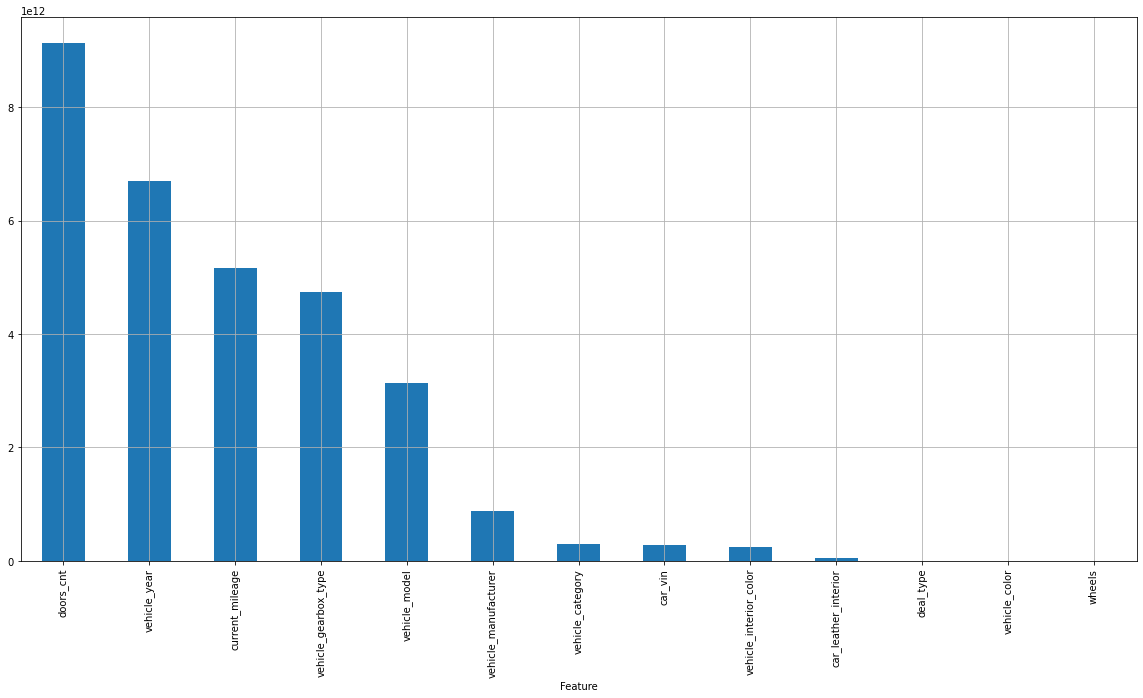

In [14]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [15]:
test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-05-16 07:32:10,011] (INFO): Prediction for test data:
array([[ 3312.0068],
       [ 7659.7183],
       [ 6590.3726],
       ...,
       [11213.242 ],
       [ 5247.242 ],
       [ 7851.0586]], dtype=float32)
Shape = (10697, 1)
[2021-05-16 07:32:10,011] (INFO): Check scores...
[2021-05-16 07:32:10,012] (INFO): OOF score: 3616.431637290628


In [16]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.head()

,row_ID,final_price
0,35000,3312.006836
1,35001,7659.718262
2,35002,6590.372559
3,35003,5267.955566
4,35004,6705.987305


In [17]:
submission.to_csv('submissions/submission_1.csv', index = False)